<h1>Spotify Charts Pipeline</h1>

<h2>Introduction</h2>

Spotify is one of the leading music streaming platforms in the world today. Founded in 2006, they initially used pirated tracks to demonstrate their proof of concept, but has since worked with record companies, big and small, and even with independent artists to rack up billions of streams across the world daily, thanks to their massive user base and proprietary algorithms.

<h2>Building the database</h2>

Using Python as our primary tool, we will build a database of Daily Top 200 Tracks, with a selection of regions and a specifiable date range. This can be accomplished through web scraping using Selenium Webdriver to simulate logins and opening of the chart page for each date, reading the HTML elements of that page, inserting into a SQLite database, then moving onto the chart page for the next date.

In [1]:
import pandas as pd

In [2]:
# regions in South East Asia with Spotify availability
# the regions can be split across multiple scraping notebooks and run simulatenously to save time,
# but keep in mind request limits
region_dict = {
    "id" : "Indonesia",
    "my" : "Malaysia",
    "ph" : "Philippines",
    "sg" : "Singapore",
    "th" : "Thailand",
    "vn" : "Vietnam"
}

In [3]:
# testing for one week
start_date = '2023-08-21'
end_date = '2023-08-28'
dates_list = pd.date_range(start=start_date, end=end_date).sort_values(ascending=True)

In [4]:
# this uses the firefox engine Geckodriver and sqlite as the database, make sure to have it installed
from selenium import webdriver
from selenium.webdriver.common.proxy import Proxy, ProxyType
from selenium.webdriver.firefox.service import Service
from webdriver_manager.firefox import GeckoDriverManager
from selenium.webdriver.chrome.options import Options
from selenium.webdriver.support.ui import WebDriverWait
from selenium.webdriver.support import expected_conditions as EC
from selenium.webdriver.common.by import By
from bs4 import BeautifulSoup
import time
import sqlite3

In [5]:
options = webdriver.FirefoxOptions()

driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)
print("Driver start")

driver.get("https://accounts.spotify.com/en/login?continue=https%3A%2F%2Fcharts.spotify.com/login")

username_field = driver.find_element(by="id", value="login-username")  # Replace with the actual username field ID
password_field = driver.find_element(by="id", value="login-password")  # Replace with the actual password field ID
login_button = driver.find_element(by="id", value="login-button")  # Replace with the actual login button ID

# Enter login credentials
username_field.send_keys("jerefe03@gmail.com")
password_field.send_keys("password123")

# Click the login button
login_button.click()

# Now you can perform your automation tasks after logging in

wait = WebDriverWait(driver, 10)
try:
    wait.until(EC.url_to_be('https://charts.spotify.com/charts/overview/global'))
    print("login success, redirecting")
    print("***")
    
    conn = sqlite3.connect('data/charts.db')
    cursor = conn.cursor()
    
    # main scraping logic
    for key in region_dict.keys():
        
        # todo: add mechanism to check if table already exists and has rows
        # but not reaching the end date (most likely disconnected), and if yes continue on the last date scraped

        cursor.execute(f'''
            CREATE TABLE IF NOT EXISTS {key} (
                title TEXT,
                rank INTEGER,
                date TEXT,
                artist TEXT,
                url TEXT,
                region TEXT,
                streams INTEGER
            )
        ''')

        sub_chart = pd.DataFrame()

        for date in dates_list:
            date_string = date.strftime("%Y-%m-%d")
            driver.get("https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string)
            try:
                WebDriverWait(driver, 10).until(EC.presence_of_element_located((By.TAG_NAME, "tr")))
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " success!")
                print("Scraping " + key + " " + date.strftime("%Y-%m-%d"))

                titles = driver.find_elements(By.CLASS_NAME, "kKOJRc")
                ranks = driver.find_elements(By.CLASS_NAME, "hgLxdb")
                artists = driver.find_elements(By.CLASS_NAME, "lfGOlT")
                artists = list(filter(lambda artists:\
                            len(artists.find_elements(By.CLASS_NAME, "bVVLJU")) > 0, artists))
                urls = driver.find_elements(By.CLASS_NAME, "gPJpnT")
                streams = driver.find_elements(By.CLASS_NAME, "cltvtH")

                for title, rank, artist_list, url, streams_count in zip (titles, ranks, artists, urls, streams):
                    title_string = title.text

                    rank_string = rank.text

                    artist_list_text_string = ""
                    artist_list_text = []
                    for artist in artist_list.find_elements(By.CLASS_NAME, "bVVLJU"):
                        artist_list_text.append(artist.text)
                    artist_list_text_string = ', '.join(map(str, artist_list_text))

                    anchor = url.find_element(By.TAG_NAME, "a")
                    anchor_string = anchor.get_attribute('href')

                    streams_count_string = streams_count.find_element(By.XPATH, './preceding-sibling::*[1]').text

                    cursor.execute(f'''INSERT INTO {key} (title, rank, date, artist, url, region, streams) VALUES (?, ?, ?, ?, ?, ?, ?)''',\
                                   (title_string, rank_string, date_string, artist_list_text_string, anchor_string, region_dict[key], streams_count_string))
                    # commit row to db
                    conn.commit()

                time.sleep(1)
            except:
                print("Page load https://charts.spotify.com/charts/view/regional-" + key + "-daily/" + date_string + " failed")
                print("Moving to next page..")
        
        print("sleeping for 10 seconds")
        print("***")
        time.sleep(10)
        
    print("Last date reached, ending driver")
    driver.quit()
        
except:
    print("login failed, ending driver")
    conn.close()
    driver.quit()

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\1455269411.py:3: DeprecationWarning: Firefox will soon stop logging to geckodriver.log by default; Specify desired logs with log_output
  driver = webdriver.Firefox(service=Service(GeckoDriverManager().install()), options=options)


Driver start
login success, redirecting
***
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-21 success!
Scraping id 2023-08-21
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-22 success!
Scraping id 2023-08-22
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-23 success!
Scraping id 2023-08-23
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-24 success!
Scraping id 2023-08-24
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-25 success!
Scraping id 2023-08-25
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-26 success!
Scraping id 2023-08-26
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-27 success!
Scraping id 2023-08-27
Page load https://charts.spotify.com/charts/view/regional-id-daily/2023-08-28 success!
Scraping id 2023-08-28
sleeping for 10 seconds
***
Page load https://charts.spotify.com/charts/view

In [6]:
# get all table names corresponding to each region
region_tables = pd.read_sql_query("SELECT * FROM sqlite_master where type='table' AND name NOT LIKE 'sqlite_%' AND name NOT LIKE '%track_data';", conn)["name"]

In [7]:
# scraped region tables
region_tables

0    id
1    my
2    ph
3    sg
4    th
5    vn
Name: name, dtype: object

In [8]:
# combine chart tables into one dataframe
charts_df = pd.DataFrame()

In [9]:
for region in region_tables:
    charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\1600905904.py:2: FutureWarning: The frame.append method is deprecated and will be removed from pandas in a future version. Use pandas.concat instead.
  charts_df = charts_df.append(pd.read_sql_query("SELECT * FROM " + region, conn))
C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\1600905904.py:2: FutureWarning: The frame.append method is deprecated and

In [10]:
# check number of scraped rows per region
charts_df["region"].value_counts()

Indonesia      1600
Malaysia       1600
Philippines    1600
Singapore      1600
Thailand       1600
Vietnam        1600
Name: region, dtype: int64

In [51]:
# extract track_id from url and drop url column
charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\3844909009.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  charts_df["track_id"] = charts_df["url"].str.replace("https://open.spotify.com/track/", "")


In [55]:
charts_df.drop("url", axis=1, inplace=True)

<h2>Check completeness in terms of date</h2>

looking deeper into the dataset using time series

In [12]:
# convert "date" column from string into pandas datetime then set as index
charts_df["date"] = pd.to_datetime(charts_df["date"])
charts_df.set_index("date", inplace=True)

In [13]:
import matplotlib.pyplot as plt
import seaborn as sns

In [99]:
def plot_region_chart_row_count_across_time(chart):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=chart.resample("D").size())
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel("row count")
    plt.title("Count of rows scraped per day")
    plt.show()

In [103]:
def plot_region_chart_row_count_distribution(chart):
    per_date_count = chart["track_id"].groupby(["date"]).count()
    sns.histplot(per_date_count)
    plt.title("Distribution of number of rows scraped")
    plt.ylabel("count of days")
    plt.xlabel("rows in day")
    plt.show()

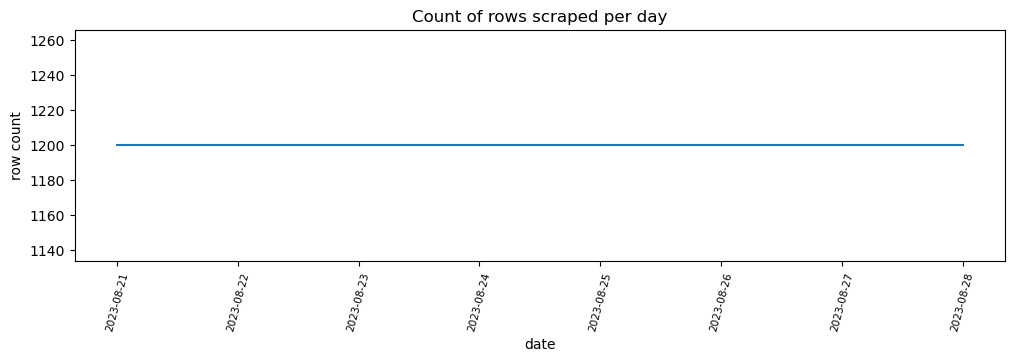

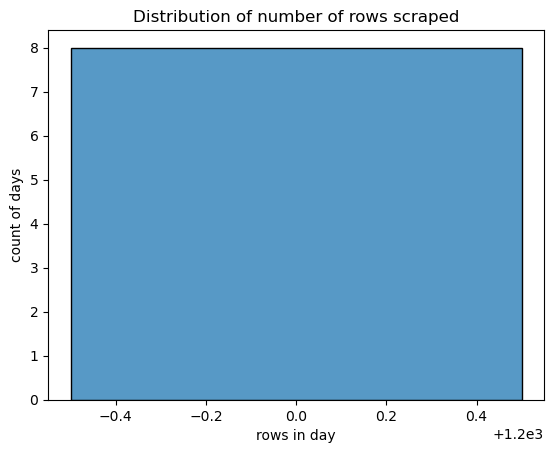

In [104]:
plot_region_chart_row_count_across_time(charts_df)
plot_region_chart_row_count_distribution(charts_df)

In [105]:
# check for missing days
date_range = pd.date_range(start=charts_df.index.min(), end=charts_df.index.max())

In [106]:
date_range

DatetimeIndex(['2023-08-21', '2023-08-22', '2023-08-23', '2023-08-24',
               '2023-08-25', '2023-08-26', '2023-08-27', '2023-08-28'],
              dtype='datetime64[ns]', freq='D')

In [107]:
for region in charts_df["region"].unique():
    print("Missing days: " + region)
    print(date_range[~date_range.isin(charts_df[charts_df["region"]==region].index)])
    print("***")

Missing days: Indonesia
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Malaysia
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Philippines
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Singapore
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Thailand
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***
Missing days: Vietnam
DatetimeIndex([], dtype='datetime64[ns]', freq='D')
***


In [108]:
# summary statistics
for region in charts_df["region"].unique():
    print("Summary statistics for streams: " + region)
    print(charts_df[charts_df["region"]==region]["streams"].describe())
    print("***")

Summary statistics for streams: Indonesia
count    1.600000e+03
mean     2.285436e+05
std      1.529093e+05
min      1.089260e+05
25%      1.350762e+05
50%      1.673055e+05
75%      2.730975e+05
max      1.303742e+06
Name: streams, dtype: float64
***
Summary statistics for streams: Malaysia
count      1600.000000
mean      23139.066875
std       14275.146652
min       11974.000000
25%       14796.000000
50%       17969.500000
75%       26314.750000
max      126812.000000
Name: streams, dtype: float64
***
Summary statistics for streams: Philippines
count      1600.000000
mean     134646.188750
std       88528.344263
min       66314.000000
25%       81780.250000
50%      100188.500000
75%      154576.250000
max      677841.000000
Name: streams, dtype: float64
***
Summary statistics for streams: Singapore
count      1600.000000
mean      12965.948125
std        9514.109508
min        6769.000000
25%        8544.750000
50%       10180.500000
75%       14182.000000
max      126582.000000
N

<h2>Get Track Data using Spotify Web Api and SpotiPy</h2>

We can get track information from Spotify Web Api and combine it with our previously extracted chart data. To do this, we identify the unique tracks in our chart data, get the track_ids of the unique tracks and and loop the track data getter over this list.

In [21]:
import time
import spotipy
from spotipy.oauth2 import SpotifyClientCredentials

In [22]:
# track data getter function
def get_track_data(t_id, client_id_param, client_secret_param):
    client_credentials_manager = SpotifyClientCredentials(client_id=client_id_param,
                                                          client_secret=client_secret_param)
    sp = spotipy.Spotify(client_credentials_manager = client_credentials_manager)
    
    track_data = sp.track(t_id)
    track_features = sp.audio_features(t_id)
    
    #get only main(first) artist
    td_list = [t_id,\
               track_data['name'],\
               track_data['artists'][0]['id'],\
               track_data['artists'][0]['name'],\
               track_data['album']['uri'].split(":")[2],\
               track_data['duration_ms'],\
               track_data['album']['release_date'],\
               track_data['popularity']]
    data = pd.DataFrame([td_list], columns = ['track_id','track_name','artist_id','artist_name','album_id','duration','release_date','popularity'])

    relevant_cols = ['danceability', 'energy', 'key', 'loudness', 'mode',\
                     'speechiness', 'acousticness', 'instrumentalness', 'liveness', 'valence', 'tempo']  
    
    #if audio features are not available
    if track_features==[None]:
        tf_data = pd.DataFrame([{x:None for x in relevant_cols}])
    else:
        tf_data = pd.DataFrame(track_features)
        tf_data = tf_data[relevant_cols]
    
    data = pd.concat([data, tf_data], axis=1)
    return data

In [23]:
downloaded_track_ids = []

def get_tracks_slice_data(tracks_slice, client_id_param, client_secret_param):

    track_df = tracks_slice
    track_list = track_df['track_id'].values
    
    for i,track_id in enumerate(track_list):    
        if track_id in downloaded_track_ids:
            continue
        else:
            print('[%d/%d] Fetching track data for %s... ' % 
                  (i+1,len(track_list),track_df[track_df['track_id']==track_id]['title'].values[0]), end = " ") 

            try:
                track_data = get_track_data(track_id, client_id_param, client_secret_param) 
                downloaded_track_ids.append(track_id)
                cursor.execute(f'''INSERT INTO track_data (track_id, track_name, artist_id, artist_name, album_id, duration, release_date, popularity, danceability, energy, key, loudness, mode, speechiness, acousticness, instrumentalness, liveness, valence, tempo) VALUES (?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?, ?)''',\
                                   (track_data["track_id"][0],
                                    track_data["track_name"][0],
                                    track_data["artist_id"][0],
                                    track_data["artist_name"][0],
                                    track_data["album_id"][0],
                                    int(track_data["duration"][0]),
                                    track_data["release_date"][0],
                                    int(track_data["popularity"][0]),
                                    float(track_data["danceability"][0]),
                                    float(track_data["energy"][0]),
                                    int(track_data["key"][0]),
                                    float(track_data["loudness"][0]),
                                    int(track_data["mode"][0]),
                                    float(track_data["speechiness"][0]),
                                    float(track_data["acousticness"][0]),
                                    float(track_data["instrumentalness"][0]),
                                    float(track_data["liveness"][0]),
                                    float(track_data["valence"][0]),
                                    float(track_data["tempo"][0])))
                conn.commit()
                print("done!")
            except Exception as e:
                print(e)

            # sleep for 100 secs per 100 requests to avoid being blocked
            if (i % 100 == 0)&(i > 0):
                time.sleep(10)

In [24]:
# tracks_slice: so we can distribute retrieval of track data across client_ids and client_secrets for bigger datasets
# downloaded_track_ids: so we can continue on last track data retrieved in case of disconnection

In [25]:
# get unique tracks in charts
charts_unique_tracks = charts_df.groupby(["title", "artist", "url"]).size().reset_index(name="count")

In [26]:
charts_unique_tracks.sort_values(by="count", ascending=False)

,title,artist,url,count
165,Die For You,The Weeknd,https://open.spotify.com/track/2LBqCSwhJGcFQeT...,48
166,Die For You (with Ariana Grande) - Remix,"The Weeknd, Ariana Grande",https://open.spotify.com/track/4W4fNrZYkobj539...,48
144,Cupid - Twin Ver.,FIFTY FIFTY,https://open.spotify.com/track/7FbrGaHYVDmfr7K...,48
140,Cruel Summer,Taylor Swift,https://open.spotify.com/track/1BxfuPKGuaTgP7a...,48
726,golden hour,JVKE,https://open.spotify.com/track/5odlY52u43F5BjB...,48
...,...,...,...,...
419,Nói Dối,Ronboogz,https://open.spotify.com/track/3ET3xHCLMGd57u0...,1
896,โอ๋,Seal Pillow,https://open.spotify.com/track/3u239EXa4wjeXmt...,1
570,Spicy,aespa,https://open.spotify.com/track/1ULdASrNy5rurl1...,1
492,Rumah,Dalia Farhana,https://open.spotify.com/track/1PydWeR9bgx8cgo...,1


In [27]:
# extract track_id from url column and drop url column
charts_unique_tracks["track_id"] = charts_unique_tracks["url"].str.replace("https://open.spotify.com/track/", "")

C:\Users\moshpit_yoshi\AppData\Local\Temp\ipykernel_8736\2350459948.py:2: FutureWarning: The default value of regex will change from True to False in a future version.
  charts_unique_tracks["track_id"] = charts_unique_tracks["url"].str.replace("https://open.spotify.com/track/", "")


In [28]:
charts_unique_tracks.drop("url", axis=1, inplace=True)

In [29]:
charts_unique_tracks

,title,artist,count,track_id
0,(It Goes Like) Nanana - Edit,Peggy Gou,13,23RoR84KodL5HWvUTneQ1w
1,10 Ngàn Năm,PC,8,76KYaCx7UjHwlnrqzcovLZ
2,17,Dept,8,3LejSFG20mSl4IzORHa7Ya
3,18,One Direction,8,3JjnGLK8IxkNLvo8Lb3KOM
4,2 faces,Mark Tuan,4,3I7s9xEyLFWbEDtsv7vYt3
...,...,...,...,...
937,訣愛 (劇集《蒼蘭訣》片頭曲),詹雯婷,6,6la3Kme7O7D01fJPxgpAS5
938,說好不哭,"Jay Chou, Ashin Chen",6,77BQceOpfvUBXgokOFHYMm
939,遇見,Stefanie Sun,4,3xJK8ywApYVEYIDhymYMC6
940,那些你很冒險的夢,JJ Lin,8,2aMN1ky0SzSEcV1QdBYbW9


In [30]:
# divide tracks to avoid timeouts from API
tracks_slice_1 = charts_unique_tracks[0:470]
tracks_slice_2 = charts_unique_tracks[470:]

In [31]:
tracks_slices = [
    tracks_slice_1,
    tracks_slice_2
]

client_ids = [
    "fe07a9a23ea54344be9aa80e33d7583b",
    "9971fa3231494ce9aa0bf8fc22622044"
]

client_secrets = [
    "710d45475521432db507f82d4f99fd54",
    "a4c187a9c6ac4b4fb01ea30cc51cfdd6"
]

In [32]:
conn = sqlite3.connect('data/charts.db')
cursor = conn.cursor()

cursor.execute(f'''
    CREATE TABLE IF NOT EXISTS track_data (
        id INTEGER PRIMARY KEY AUTOINCREMENT,
        track_id TEXT,
        track_name TEXT,
        artist_id TEXT,
        artist_name TEXT,
        album_id TEXT,
        duration INTEGER,
        release_date TEXT,
        popularity INTEGER,
        danceability FLOAT,
        energy FLOAT,
        key INTEGER,
        loudness FLOAT,
        mode INTEGER,
        speechiness FLOAT,
        acousticness FLOAT,
        instrumentalness FLOAT,
        liveness FLOAT,
        valence FLOAT,
        tempo FLOAT
    )
''')

In [35]:
for iteration in range(0,2):
    print("***")
    print("Iteration " + str(iteration))
    get_tracks_slice_data(tracks_slices[iteration], client_ids[iteration], client_secrets[iteration])

***
Iteration 0
[113/470] Fetching track data for Cheating on You...  done!
[114/470] Fetching track data for Chemical...  done!
[115/470] Fetching track data for Cho Tôi Lang Thang...  done!
[116/470] Fetching track data for Choosy...  done!
[117/470] Fetching track data for Christmas Tree...  done!
[118/470] Fetching track data for Chuyện Rằng...  done!
[119/470] Fetching track data for Chuyện Đôi Ta (feat. Muộii)...  done!
[120/470] Fetching track data for Chìm Sâu...  done!
[121/470] Fetching track data for Chúng Ta Của Hiện Tại...  done!
[122/470] Fetching track data for Chơi Như Tụi Mỹ...  done!
[123/470] Fetching track data for Chạy Khỏi Thế Giới Này...  done!
[124/470] Fetching track data for Chết Trong Em...  done!
[125/470] Fetching track data for Chỉ Một Đêm Nữa Thôi...  done!
[126/470] Fetching track data for Chờ Đợi Có Đáng Sợ...  done!
[127/470] Fetching track data for Cincin...  done!
[128/470] Fetching track data for Cinta Dan Rahasia...  done!
[129/470] Fetching track 

[250/470] Fetching track data for Higa...  done!
[251/470] Fetching track data for Hilang Tanpa Bilang...  done!
[252/470] Fetching track data for Hitam Putih...  done!
[253/470] Fetching track data for Hoa Cỏ Lau...  done!
[254/470] Fetching track data for Honeymoon Avenue...  done!
[255/470] Fetching track data for Horizon...  done!
[256/470] Fetching track data for How You Like That...  done!
[257/470] Fetching track data for Hukum - Thalaivar Alappara...  done!
[258/470] Fetching track data for Huling Sandali (Tayo Sa Huling Buwan Ng Taon Official Soundtrack)...  done!
[259/470] Fetching track data for Hype Boy...  done!
[260/470] Fetching track data for I AM...  done!
[261/470] Fetching track data for I Ain't Worried...  done!
[262/470] Fetching track data for I Can See You (Taylor’s Version) (From The Vault)...  done!
[263/470] Fetching track data for I DO...  done!
[264/470] Fetching track data for I Like Me Better...  done!
[265/470] Fetching track data for I Love You So...  do

[389/470] Fetching track data for Một Công Đôi Việc (feat. HURRYKNG & HIEUTHUHAI)...  done!
[390/470] Fetching track data for Một Ngàn Nỗi Đau...  done!
[391/470] Fetching track data for Một Ngày Chẳng Nắng...  done!
[392/470] Fetching track data for N33d you...  done!
[393/470] Fetching track data for NGTANOISE...  done!
[394/470] Fetching track data for NIGHT DANCER...  done!
[395/470] Fetching track data for NVMD...  done!
[396/470] Fetching track data for Nahuhulog...  done!
[397/470] Fetching track data for Nangangamba...  done!
[398/470] Fetching track data for Nanti Kita Seperti Ini...  done!
[399/470] Fetching track data for Need You...  done!
[400/470] Fetching track data for Nemen - Hiphop Dangdut Version...  done!
[401/470] Fetching track data for Nemu...  done!
[402/470] Fetching track data for New Jeans...  done!
[403/470] Fetching track data for Ngayong Gabi...  done!
[404/470] Fetching track data for Nghe Như Tình Yêu...  done!
[405/470] Fetching track data for Ngày Em Đ

[55/472] Fetching track data for See You Again (feat. Kali Uchis)...  done!
[56/472] Fetching track data for Selamat (Selamat Tinggal)...  done!
[57/472] Fetching track data for Seluruh Nafas Ini...  done!
[58/472] Fetching track data for Semata Karenamu...  done!
[59/472] Fetching track data for Sempurna...  done!
[60/472] Fetching track data for Sempurna...  done!
[61/472] Fetching track data for Semua Aku Dirayakan...  done!
[62/472] Fetching track data for Separuh Aku...  done!
[63/472] Fetching track data for Separuh Nafas...  done!
[64/472] Fetching track data for Sepatu...  done!
[65/472] Fetching track data for Serana...  done!
[66/472] Fetching track data for Sesaat Kau Hadir...  done!
[67/472] Fetching track data for Set Fire to the Rain...  done!
[68/472] Fetching track data for Set Me Free Pt.2...  done!
[69/472] Fetching track data for Seven (feat. Latto) (Explicit Ver.)...  done!
[70/472] Fetching track data for Sewindu...  done!
[71/472] Fetching track data for Shake It 

[189/472] Fetching track data for Umaasa...  done!
[190/472] Fetching track data for Under The Influence...  done!
[191/472] Fetching track data for Unstoppable...  done!
[192/472] Fetching track data for Until I Found You...  done!
[193/472] Fetching track data for Until I Found You (with Em Beihold) - Em Beihold Version...  done!
[194/472] Fetching track data for Untuk Mencintaimu...  done!
[195/472] Fetching track data for Untuk Perempuan Yang Sedang Di Pelukan...  done!
[196/472] Fetching track data for Usai...  done!
[197/472] Fetching track data for Used To Be Young...  done!
[198/472] Fetching track data for Usik...  done!
[199/472] Fetching track data for Very Very Small...  done!
[200/472] Fetching track data for Vinflow...  done!
[201/472] Fetching track data for Viva La Vida...  done!
[202/472] Fetching track data for Vành Khuyên Nhỏ (feat. Liu Grace)...  done!
[203/472] Fetching track data for Vì Anh Đâu Có Biết...  done!
[204/472] Fetching track data for VỀ QUÊ (feat. Mike

[322/472] Fetching track data for งานเต้นรำ...  done!
[323/472] Fetching track data for จดหมาย...  done!
[324/472] Fetching track data for จะมอบความรัก...  done!
[325/472] Fetching track data for จังหวะตกหลุมรัก - Magic Moment...  done!
[326/472] Fetching track data for จากตรงนี้ที่(เคย)สวยงาม [La La Bye]...  done!
[327/472] Fetching track data for จำเก่ง (Slipped Your Mind)...  done!
[328/472] Fetching track data for ฉบับปรับปรุง...  done!
[329/472] Fetching track data for ฉันคือนักสะสมความเศร้า...  done!
[330/472] Fetching track data for ฉันมันเป็นคนแบบนี้...  done!
[331/472] Fetching track data for ชอบตัวเองตอนอยู่กับเธอ...  done!
[332/472] Fetching track data for ช่วงเวลา...  done!
[333/472] Fetching track data for ซูลูปาก้า ตาปาเฮ้...  done!
[334/472] Fetching track data for ดอกไม้ไฟ...  done!
[335/472] Fetching track data for ต่อจากคืนนี้ (ฉันจะไม่มีเธอแล้ว) - Gloomy...  done!
[336/472] Fetching track data for ต่อจากนี้เพลงรักทุกเพลงจะเป็นของเธอเท่านั้น...  done!
[337/472] Fetchi

[456/472] Fetching track data for 想見你想見你想見你(電視劇"想見你"片尾曲)...  done!
[457/472] Fetching track data for 我会等...  done!
[458/472] Fetching track data for 我走后 - 发行版...  done!
[459/472] Fetching track data for 摯友...  done!
[460/472] Fetching track data for 摯友...  done!
[461/472] Fetching track data for 擱淺...  done!
[462/472] Fetching track data for 晴天...  done!
[463/472] Fetching track data for 最後一堂課 - 《媽,別鬧了!》影集片尾曲...  done!
[464/472] Fetching track data for 有些...  done!
[465/472] Fetching track data for 永不失聯的愛...  done!
[466/472] Fetching track data for 演員...  done!
[467/472] Fetching track data for 烏梅子醬...  done!
[468/472] Fetching track data for 訣愛 (劇集《蒼蘭訣》片頭曲)...  done!
[469/472] Fetching track data for 說好不哭...  done!
[470/472] Fetching track data for 遇見...  done!
[471/472] Fetching track data for 那些你很冒險的夢...  done!
[472/472] Fetching track data for 飞鸟和蝉...  done!


In [36]:
pd.read_sql_query("SELECT * FROM track_data", conn)

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,231545,2023-06-15,94,0.671,0.876,7,-5.681,0,0.0352,0.1200,0.188000,0.0823,0.964,129.998
1,2,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,240000,2019-12-21,60,0.676,0.691,4,-12.011,0,0.0997,0.9490,0.108000,0.1300,0.415,124.032
2,3,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,210875,2022-11-15,62,0.748,0.777,10,-4.783,1,0.0430,0.0471,0.004260,0.1260,0.970,121.034
3,4,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,248360,2014-11-17,82,0.681,0.582,6,-7.760,0,0.0313,0.2200,0.000000,0.1190,0.221,124.038
4,5,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,172265,2022-08-26,62,0.733,0.453,2,-10.942,1,0.0340,0.1150,0.007840,0.3370,0.658,139.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,937,6la3Kme7O7D01fJPxgpAS5,訣愛 (劇集《蒼蘭訣》片頭曲),7hmSHY9HVVQKejpGbPbo16,詹雯婷,11KVIZFGZ34hRCfrIr1oSt,189295,2022-08-15,69,0.450,0.620,11,-6.492,1,0.0365,0.3130,0.000000,0.0672,0.169,142.026
937,938,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,220693,2022-07-14,62,0.513,0.363,10,-11.219,1,0.0306,0.5300,0.000000,0.0792,0.383,151.828
938,939,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,209760,2003,67,0.631,0.233,8,-13.016,1,0.0329,0.8410,0.000003,0.2280,0.442,91.864
939,940,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,244470,2012-01-12,65,0.490,0.487,2,-5.276,1,0.0341,0.7850,0.000000,0.2590,0.279,135.870


In [47]:
# check what track data was not extracted compared to chart data
charts_unique_tracks[~charts_unique_tracks["track_id"].isin(pd.read_sql_query("SELECT * FROM track_data", conn)["track_id"])]

,title,artist,count,track_id
42,"Anh Là Ai? (feat. Dick, DT & UMIE)","RAP VIỆT, Dick, DT, UMIE",8,6HpkHTTwfVmSoopeloHqOp


In [48]:
# no track data avaliable for this one (aside from popularity)
get_track_data("6HpkHTTwfVmSoopeloHqOp", "fe07a9a23ea54344be9aa80e33d7583b", "710d45475521432db507f82d4f99fd54")

,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,6HpkHTTwfVmSoopeloHqOp,"Anh Là Ai? (feat. Dick, DT & UMIE)",1cPpd989kghzlZqfpP4KwL,RAP VIỆT,4YSxnHCean6ZAsYwB1V9nW,223783,2023-08-09,54,None,None,None,None,None,None,None,None,None,None,None


<h2>Merging charts and track data</h2>

In [59]:
# check dtypes
charts_df.dtypes

title       object
rank         int64
artist      object
region      object
streams     object
track_id    object
dtype: object

In [60]:
# change streams dtypes from object to integer
charts_df["streams"] = charts_df["streams"].str.replace(",","").astype(int)

In [64]:
# inspect
charts_df

,title,rank,artist,region,streams,track_id
date,,,,,,
2023-08-21,Jiwa Yang Bersedih,1,Ghea Indrawari,Indonesia,1218929,6XsFgTG4dY768oIB4Dmeu0
2023-08-21,Tak Segampang Itu,2,Anggi Marito,Indonesia,1043882,26cvTWJq2E1QqN4jyH2OTU
2023-08-21,Komang,3,Raim Laode,Indonesia,735587,2AaaE0qvFWtyT8srKNfRhH
2023-08-21,Rayuan Perempuan Gila,4,Nadin Amizah,Indonesia,695957,1nYdkPCbHdYi4w7s2L6SHA
2023-08-21,Sial,5,Mahalini,Indonesia,671954,6dXiWwFrcGieqnoLYzPNp5
...,...,...,...,...,...,...
2023-08-28,Gác Lại Âu Lo (feat. Miu Lê),196,"Da LAB, Miu Lê",Vietnam,13657,1mKDbug8bbfDmLe7I4CJpe
2023-08-28,Nơi Này Có Anh,197,Sơn Tùng M-TP,Vietnam,13616,5HbLlcJogki9rRq2KfkGQP
2023-08-28,ái,198,tlinh,Vietnam,13570,3Gr6ucPp3qJbBZ3yrGmZTt


In [131]:
# store track data to dataframe
track_data = pd.read_sql_query("SELECT * FROM track_data", conn)

In [132]:
# inspect
track_data

,id,track_id,track_name,artist_id,artist_name,album_id,duration,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo
0,1,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,231545,2023-06-15,94,0.671,0.876,7,-5.681,0,0.0352,0.1200,0.188000,0.0823,0.964,129.998
1,2,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,240000,2019-12-21,60,0.676,0.691,4,-12.011,0,0.0997,0.9490,0.108000,0.1300,0.415,124.032
2,3,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,210875,2022-11-15,62,0.748,0.777,10,-4.783,1,0.0430,0.0471,0.004260,0.1260,0.970,121.034
3,4,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,248360,2014-11-17,82,0.681,0.582,6,-7.760,0,0.0313,0.2200,0.000000,0.1190,0.221,124.038
4,5,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,172265,2022-08-26,62,0.733,0.453,2,-10.942,1,0.0340,0.1150,0.007840,0.3370,0.658,139.970
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,937,6la3Kme7O7D01fJPxgpAS5,訣愛 (劇集《蒼蘭訣》片頭曲),7hmSHY9HVVQKejpGbPbo16,詹雯婷,11KVIZFGZ34hRCfrIr1oSt,189295,2022-08-15,69,0.450,0.620,11,-6.492,1,0.0365,0.3130,0.000000,0.0672,0.169,142.026
937,938,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,220693,2022-07-14,62,0.513,0.363,10,-11.219,1,0.0306,0.5300,0.000000,0.0792,0.383,151.828
938,939,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,209760,2003,67,0.631,0.233,8,-13.016,1,0.0329,0.8410,0.000003,0.2280,0.442,91.864
939,940,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,244470,2012-01-12,65,0.490,0.487,2,-5.276,1,0.0341,0.7850,0.000000,0.2590,0.279,135.870


In [133]:
# drop unneeded columns then set track_id as index
track_data = track_data.reset_index(drop=True).drop(["id"], axis=1)

In [134]:
# convert duration to duration_mins
track_data["duration_mins"] = track_data["duration"]/60000
track_data.drop("duration", axis=1, inplace=True)

In [135]:
# inspect
track_data

,track_id,track_name,artist_id,artist_name,album_id,release_date,popularity,danceability,energy,key,loudness,mode,speechiness,acousticness,instrumentalness,liveness,valence,tempo,duration_mins
0,23RoR84KodL5HWvUTneQ1w,(It Goes Like) Nanana - Edit,2mLA48B366zkELXYx7hcDN,Peggy Gou,2LVDNOUUy2g8517ZEtQIcK,2023-06-15,94,0.671,0.876,7,-5.681,0,0.0352,0.1200,0.188000,0.0823,0.964,129.998,3.859083
1,76KYaCx7UjHwlnrqzcovLZ,10 Ngàn Năm,3HD3V1nGFPwepBO7064Ij0,PC,1LkA7FjIQpuZBgxdd3nNvF,2019-12-21,60,0.676,0.691,4,-12.011,0,0.0997,0.9490,0.108000,0.1300,0.415,124.032,4.000000
2,3LejSFG20mSl4IzORHa7Ya,17,1zVBNAJivxfj3HygJZOSw3,Dept,1seGyT8ATQOf4G8c9QR8sP,2022-11-15,62,0.748,0.777,10,-4.783,1,0.0430,0.0471,0.004260,0.1260,0.970,121.034,3.514583
3,3JjnGLK8IxkNLvo8Lb3KOM,18,4AK6F7OLvEQ5QYCBNiQWHq,One Direction,4gCNyS7pidfK3rKWhB3JOY,2014-11-17,82,0.681,0.582,6,-7.760,0,0.0313,0.2200,0.000000,0.1190,0.221,124.038,4.139333
4,3I7s9xEyLFWbEDtsv7vYt3,2 faces,4l1q0z9xeJcJw73Gxc6gCB,Mark Tuan,5qzQi2sdmwHfKe1BPMYi1N,2022-08-26,62,0.733,0.453,2,-10.942,1,0.0340,0.1150,0.007840,0.3370,0.658,139.970,2.871083
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
936,6la3Kme7O7D01fJPxgpAS5,訣愛 (劇集《蒼蘭訣》片頭曲),7hmSHY9HVVQKejpGbPbo16,詹雯婷,11KVIZFGZ34hRCfrIr1oSt,2022-08-15,69,0.450,0.620,11,-6.492,1,0.0365,0.3130,0.000000,0.0672,0.169,142.026,3.154917
937,77BQceOpfvUBXgokOFHYMm,說好不哭,2elBjNSdBE2Y3f0j1mjrql,Jay Chou,1rBr9FeLlp5ueSKtE89FZa,2022-07-14,62,0.513,0.363,10,-11.219,1,0.0306,0.5300,0.000000,0.0792,0.383,151.828,3.678217
938,3xJK8ywApYVEYIDhymYMC6,遇見,0SIXZXJCAhNU8sxK0qm7hn,Stefanie Sun,6CGJuQoWMkq1rmStrYbRzr,2003,67,0.631,0.233,8,-13.016,1,0.0329,0.8410,0.000003,0.2280,0.442,91.864,3.496000
939,2aMN1ky0SzSEcV1QdBYbW9,那些你很冒險的夢,7Dx7RhX0mFuXhCOUgB01uM,JJ Lin,5nAilSc60xebtjFfRr6m2V,2012-01-12,65,0.490,0.487,2,-5.276,1,0.0341,0.7850,0.000000,0.2590,0.279,135.870,4.074500


In [140]:
# reset index to prevent losing datetimeindex
charts_df.reset_index(inplace=True)

In [141]:
# merge charts and track data
charts_track_data_df = pd.merge(charts_df, track_data)

In [142]:
# inspect
charts_track_data_df.set_index('date', inplace=True)

In [143]:
# export to csv for convenience
charts_track_data_df.to_csv("data/charts_track_data_df.csv")

<h2>Visualizing Feature Median Values Across Time</h2>

In [149]:
from matplotlib.dates import MonthLocator, DateFormatter

In [154]:
def plot_feature(feature, stat_metric, period, df):
    plt.figure(figsize=(12, 3))
    sns.lineplot(data=df.resample(period).agg({feature:stat_metric}), x="date", y=feature)
    plt.xticks(rotation=75, fontsize=7.5)
    plt.ylabel(stat_metric + " " + feature)
    months = MonthLocator()
    months_fmt = DateFormatter('%b %Y')
    plt.gca().xaxis.set_major_locator(months)
    plt.gca().xaxis.set_major_formatter(months_fmt)
    plt.show()

In [155]:
features = ["duration_mins", "popularity", "danceability", "energy", "loudness", "speechiness", "acousticness", "instrumentalness", "liveness", "valence", "tempo", "streams"]

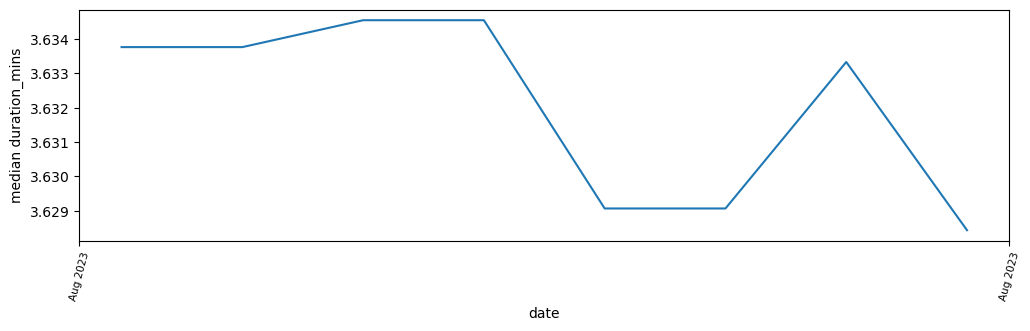

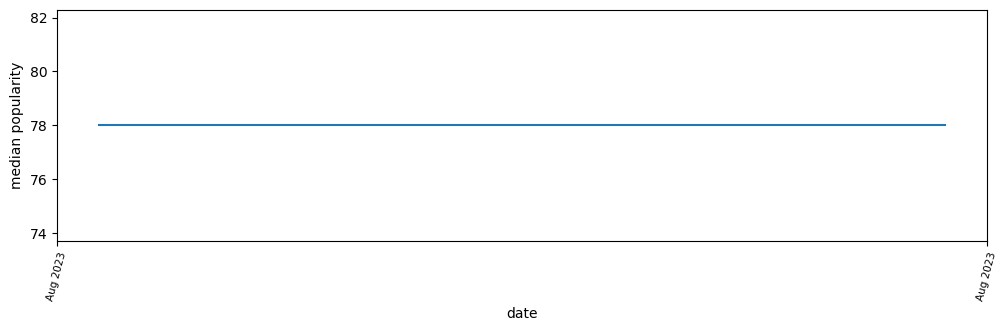

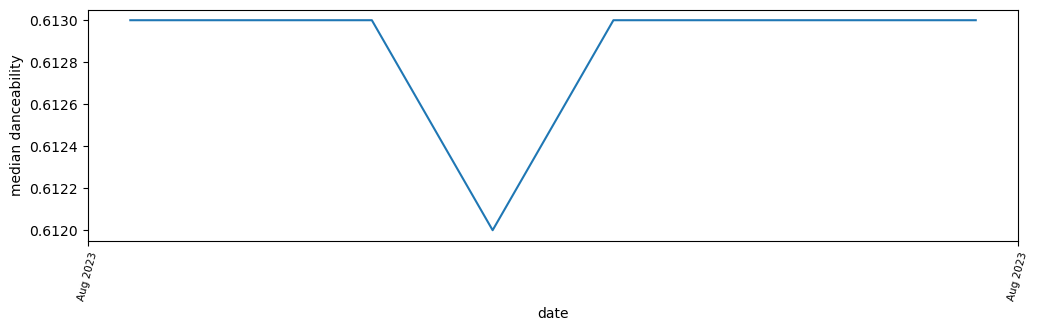

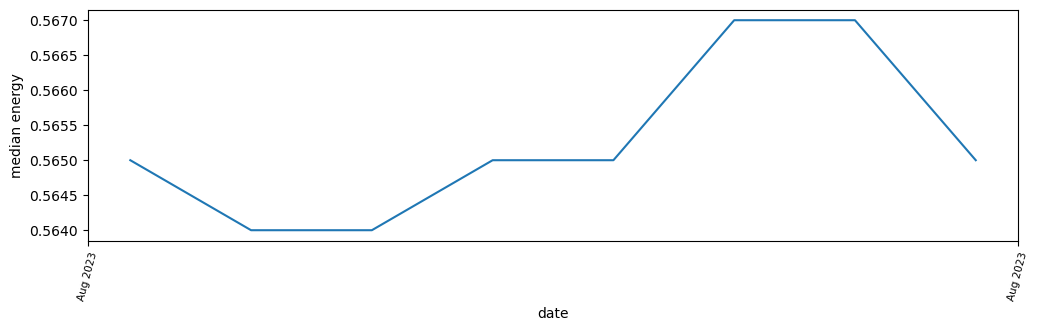

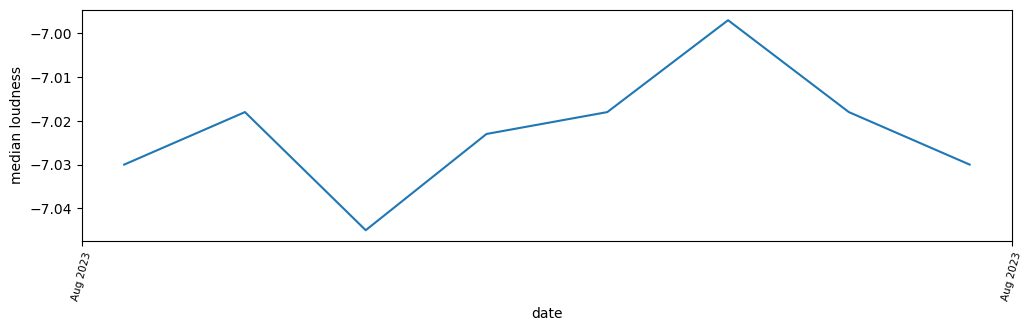

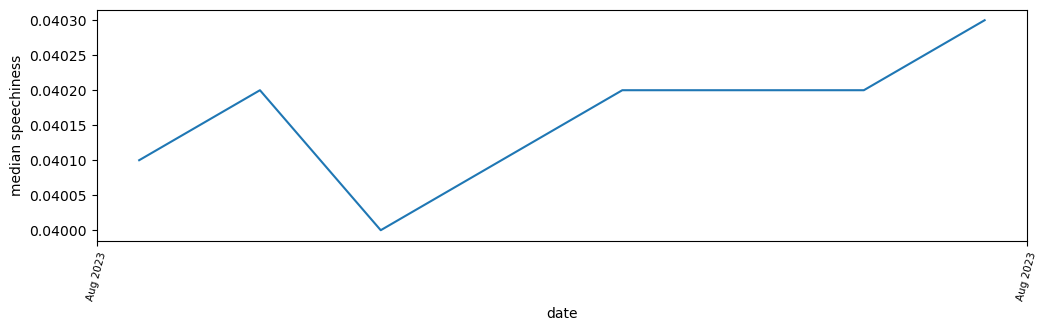

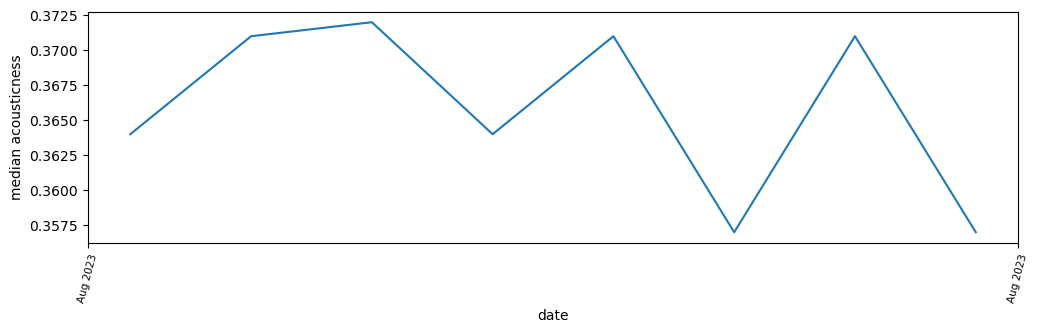

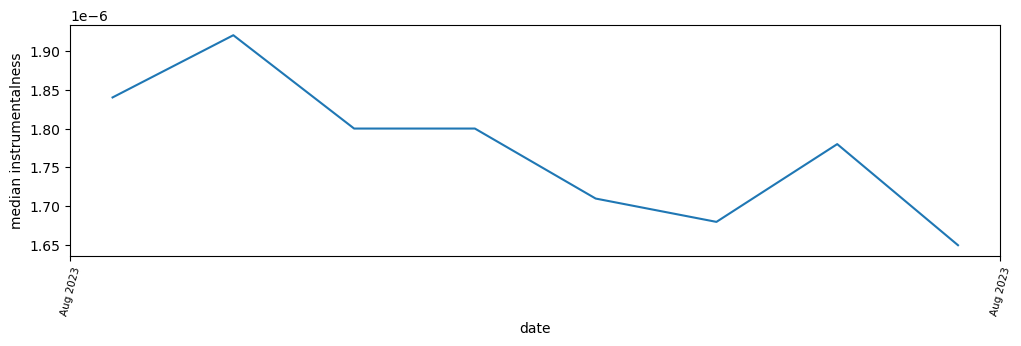

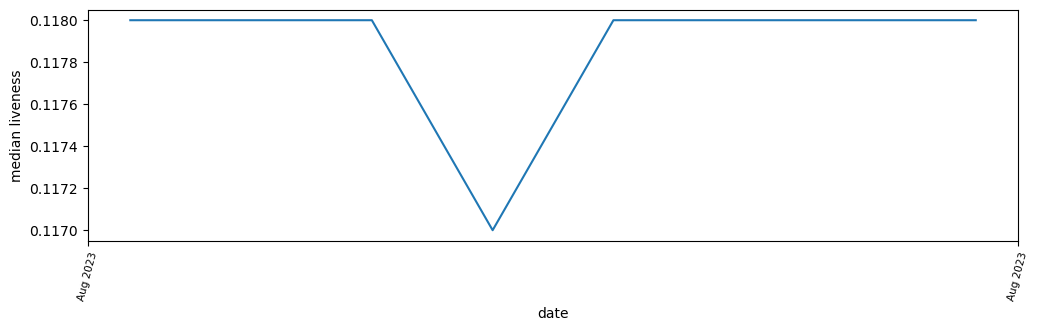

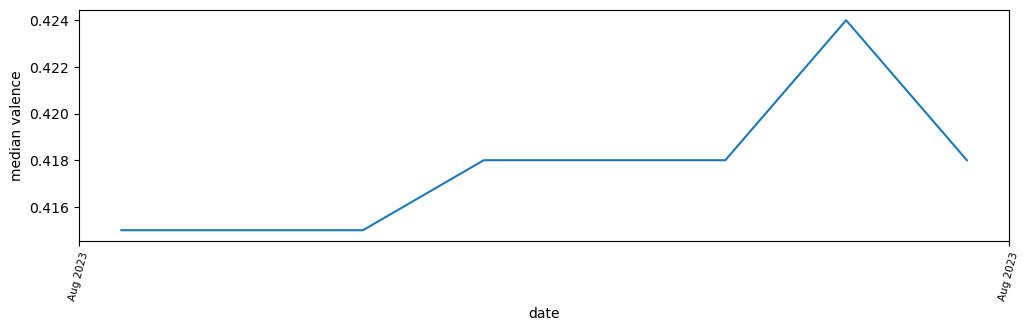

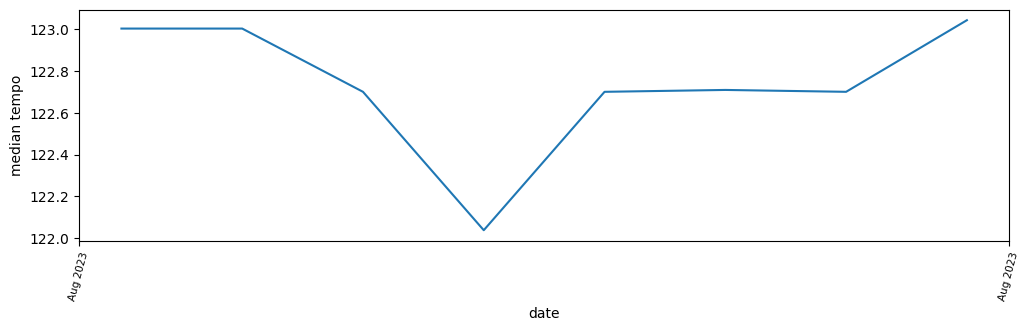

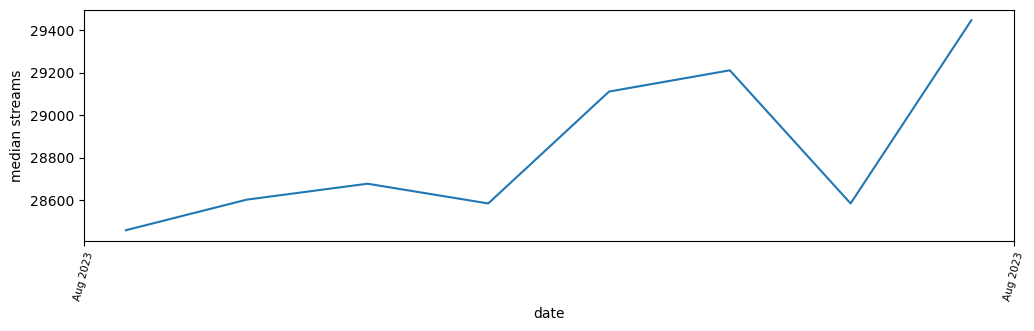

In [156]:
stat_metric = "median";
period = "D";
for feature in features:
    plot_feature(feature, stat_metric, period, charts_track_data_df)